In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from os.path import join
from matplotlib.gridspec import GridSpec

from scipy.stats import fligner, mannwhitneyu
from nilearn import plotting, datasets, surface

#from ..utils import assign_region_names, plot_surfaces, jili_sidak_mc

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    '''
    Plots of medial and lateral left and right surface views from nifti volume
    '''
    
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation='nearest')
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation='nearest')
    
    fig = plt.figure(figsize=(12,4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection='3d')
    ax1 = fig.add_subplot(gs[1], projection='3d')
    ax2 = fig.add_subplot(gs[2], projection='3d')
    ax3 = fig.add_subplot(gs[3], projection='3d')
    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax0, darkness=1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax1)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax2)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax3)
    return figure

In [3]:
def assign_region_names(df, missing=False):
    '''
    Input: 
    df = dataframe (variable x columns) with column containing region names in ABCD var ontology, 
    Output: 
    df = same dataframe, but with column mapping region variables to actual region names
    missing = optional, list of ABCD region names not present in region_names dictionary
    '''
    region_names = pd.read_csv('region_names.csv', header=0, index_col=0)
    print(region_names.index)
    # read in region names 
    missing = []
    df = df.copy()
    if not 'long_region' in df.columns:
        df['measure'] = ''
        df['region'] = ''
        df['modality'] = ''
        df['atlas'] = ''
        df['long_region'] = ''
        df['hemisphere'] = ''
        df['cog'] = ''
        df['cog2'] = ''
        df['sys'] = ''
        for var in df.index:
            #print(var)
            trim_var = var.split('.')[0]
            
            var_list = trim_var.split('_')
            
            df.at[var, 'modality'] = var_list[0]
            df.at[var, 'measure'] = var_list[1]
            df.at[var, 'atlas'] = var_list[2]
            region = '_'.join(var_list[3:])
            df.at[var, 'region'] = region
            if 'scs' in trim_var:
                if 'rsirni' in var:
                    df.at[var, 'measure'] = 'rsirnigm'
                elif 'rsirnd' in var:
                    df.at[var, 'measure'] = 'rsirndgm'
                elif '_scs_' in region:
                    temp = region.split('_scs_')
                    one = region_names.loc[temp[0]]
                    #print(one, two)
                    two = region_names.loc[temp[1]]
                    #print(one, two)
                    region_name = f'{one["name"]} {two["name"]}'
                    #print(region_name)
                    hemisphere = two['hemi']
                    df.at[var, 'long_region'] = region_name
                    df.at[var, 'hemisphere'] = hemisphere
                    df.at[var, 'measure'] = 'subcortical-network fc'
                    df.at[var, 'cog'] = f'{one["cog"]} + {two["cog"]}'
                    df.at[var, 'cog2'] = f'{one["cog2"]} + {two["cog2"]}'
                    df.at[var, 'sys'] = f'{one["sys"]} + {two["sys"]}'
                else:
                    pass
            elif '_ngd_' in region:
                temp = region.split('_ngd_')
                if temp[0] == temp[1]:
                    df.at[var, 'measure'] = 'within-network fc'
                else:
                    df.at[var, 'measure'] = 'between-network fc'
                one = region_names.loc[temp[0]]
                two = region_names.loc[temp[1]]
                region_name = f"{one['name']}-{two['name']}"
                #print(one['name'], two['name'], region_name)
                hemisphere = two['hemi']
                df.at[var, 'long_region'] = region_name
                df.at[var, 'hemisphere'] = hemisphere
                df.at[var, 'cog'] = f'{one["cog"]} + {two["cog"]}'
                df.at[var, 'cog2'] = f'{one["cog2"]} + {two["cog2"]}'
                df.at[var, 'sys'] = f'{one["sys"]} + {two["sys"]}'
            elif str(region) not in (region_names.index):
                missing.append(region)
            else:
                one = region_names.loc[region]
                df.at[var, 'long_region'] = one['name']
                df.at[var, 'hemisphere'] = one['hemi']
                df.at[var, 'cog'] = one["cog"]
                df.at[var, 'cog2'] = one["cog2"]
                df.at[var, 'sys'] = one["sys"]

        df = df[df['measure'] != 't1w']
        df = df[df['measure'] != 't2w']
    else:
        pass

    print(f'missed {len(missing)} regions bc they weren\'t in the dict')
    return df

In [4]:
sns.set(style='white', context='talk')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier'

In [5]:
crayons = sns.crayon_palette(['Aquamarine', 'Fuchsia', 
                              'Jungle Green', 'Fern'])

In [6]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [7]:
df = pd.read_pickle(join(PROJ_DIR, DATA_DIR, "data_qcd.pkl"))

In [8]:
df.filter(regex='thick.*change_score', axis=1)

,smri_thick_cdk_banksstslh.change_score,smri_thick_cdk_cdacatelh.change_score,smri_thick_cdk_cdmdfrlh.change_score,smri_thick_cdk_cuneuslh.change_score,smri_thick_cdk_ehinallh.change_score,smri_thick_cdk_fusiformlh.change_score,smri_thick_cdk_ifpllh.change_score,smri_thick_cdk_iftmlh.change_score,smri_thick_cdk_ihcatelh.change_score,smri_thick_cdk_locclh.change_score,...,smri_thick_cdk_rracaterh.change_score,smri_thick_cdk_rrmdfrrh.change_score,smri_thick_cdk_sufrrh.change_score,smri_thick_cdk_suplrh.change_score,smri_thick_cdk_sutmrh.change_score,smri_thick_cdk_smrh.change_score,smri_thick_cdk_frpolerh.change_score,smri_thick_cdk_tmpolerh.change_score,smri_thick_cdk_trvtmrh.change_score,smri_thick_cdk_insularh.change_score
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV07HGA3B7,0.803776,0.061212,-0.635668,-1.621987,-0.940178,-0.097543,0.405680,-0.013172,0.629408,-0.669912,...,-0.412159,-0.723388,-0.775946,-0.696231,-1.568942,-0.992712,0.609568,0.253537,-2.213708,-1.678859
NDAR_INV07RAHHYH,-0.633268,2.720489,-0.676056,-3.185691,-0.306150,-0.957145,-1.554084,-0.170152,-2.356539,-0.224299,...,0.342915,-1.798853,-1.453608,-1.172914,0.313112,0.175631,-1.838740,0.188837,-0.482239,-2.765303
NDAR_INV08P1JKNE,-2.254714,-1.267327,3.529162,3.920653,7.847186,2.096802,2.790395,2.577762,-0.970828,2.742857,...,2.159229,1.852698,4.089980,5.286255,1.888738,1.138894,-7.848870,7.988678,0.326122,0.452462
NDAR_INV09AUXBBT,-0.507301,3.281378,0.792608,1.094303,1.470148,1.015596,-0.447011,-0.985555,-0.174058,-0.814701,...,3.269486,0.123391,0.156496,0.354287,6.516504,0.321536,-2.758012,0.877096,-0.265336,-0.537791
NDAR_INV09ZE6UUK,-4.225535,-0.067744,-0.038448,-1.846613,-4.350045,-1.116728,-2.280147,-2.397990,-2.701491,-5.014646,...,-4.281608,-0.958084,0.384912,-4.179394,-2.663089,-3.102128,-5.793315,-12.821239,-3.980676,-0.763085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVXXHGW734,-2.506124,0.598086,-2.162757,-1.394901,-4.407952,-2.392177,-2.561184,-2.822719,-1.914648,-2.587269,...,-5.181036,-1.424390,-1.453737,-1.894317,-1.237624,-1.216717,-1.041667,0.718954,-3.425656,-2.735657
NDAR_INVZKJXBJMM,-2.195034,-0.827887,-0.403438,-2.400680,-0.505689,-1.676934,-0.436072,-0.949209,-0.944018,-1.333333,...,-1.724451,-1.049475,-0.261097,-0.078958,-0.770152,-0.017203,-3.355927,-3.085299,-0.306031,-0.744731
NDAR_INVZKT1BV8Y,-0.794506,-0.493057,-0.855087,-0.691643,0.451577,-0.237540,-1.581176,-1.131761,0.221453,-0.303349,...,1.003484,-1.237770,-0.351297,0.703297,-0.737651,0.275862,-0.123917,-0.768183,-1.094929,-0.305408


In [9]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex=".*cortgord.*").columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [10]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [11]:
df[['pds_p_ss_female_category_2.baseline_year_1_arm_1',
    'pds_p_ss_male_category_2.baseline_year_1_arm_1']]
df['pds_p_ss_category_2.baseline_year_1_arm_1'] = df['pds_p_ss_female_category_2.baseline_year_1_arm_1'].fillna(0) + df['pds_p_ss_male_category_2.baseline_year_1_arm_1'].fillna(0)
df['pds_p_ss_category_2.baseline_year_1_arm_1'].replace({0: np.nan}, inplace=True)

In [12]:
tests = ['variance', 
         'fligner_sex',
         'fligner_puberty',
         #'fligner_puberty_4',
         #'fligner_puberty_5',
         'fligner_raceth', 
         'fligner_income', 
         'fligner_edu', 
         'fligner_marital', 
         'fligner_age', 
         #'fligner_scanner'
        ]

In [13]:
df.drop(df.filter(regex="nihtbx.*").columns, axis=1, inplace=True)
temp_df = df.dropna(thresh=100)

print(temp_df['interview_age.baseline_year_1_arm_1'].min() / 12, temp_df['interview_age.2_year_follow_up_y_arm_1'].max() / 12)

8.916666666666666 13.833333333333334


In [14]:
var_df = pd.read_pickle(join(PROJ_DIR, 
                          OUTP_DIR, 
                          'variance_flinger-alpha<0.0.pkl'))


In [15]:
var_df.drop(var_df.filter(regex=".*cortgord.*"), axis=0, inplace=True)

In [16]:
img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

In [17]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
fmri_var = img_modalities['fmri'].columns
fmri_cor_var = img_modalities['fmri'].filter(regex='_c.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns
morph = img_modalities['smri'].filter(regex='.*vol.*').columns

fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [18]:
puberty = 'pds_p_ss_category_2.baseline_year_1_arm_1'
race = 'race_ethnicity.baseline_year_1_arm_1'
income = 'demo_comb_income_v2.baseline_year_1_arm_1'
edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
age = 'interview_age.baseline_year_1_arm_1'
sex = 'sex.baseline_year_1_arm_1'
mri = 'mri_info_manufacturer.baseline_year_1_arm_1'
marry = "demo_prnt_marital_v2.baseline_year_1_arm_1"

## Visualizing brain heterogeneity across non-brain variables
1. Variability across all brain measures
2. Per modality
3. Across the brain
4. Across developmental variables
5. Across demographic variables

for var in var_df.index:
    for modality in img_modalities.keys():
        if var in img_modalities[modality]:
            var_df.at[var, 'modality'] = modality

In [19]:
devt = ['fligner_age', 
        'fligner_sex',
        'fligner_puberty']
demo =  ['fligner_raceth',
         'fligner_income',
         'fligner_edu',
         'fligner_marital', 
         #'fligner_scanner'
        ]

In [20]:
demo_alphas = [f'{i}_alpha' for i in demo]
devt_alphas = [f'{i}_alpha' for i in devt]

In [21]:
# build a df that categorizes measures (i.e., 'smri', 'cortical volume', 'region')
for var in var_df.index:
    #print(var)
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        var_df.at[var, 'modality'] = 'smri'
        var_df.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            var_df.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            var_df.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            var_df.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            var_df.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            var_df.at[var, 'measure'] = 'gmvol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        var_df.at[var, 'modality'] = var_list[0]
        var_df.at[var, 'measure'] = var_list[1]
        var_df.at[var, 'atlas'] = var_list[2]
        var_df.at[var, 'region'] = '_'.join(var_list[3:])

In [22]:
var_df['atlas'].unique()

array(['cdk', 'scs', 'ngd', 'fib', 'fiberat'], dtype=object)

In [23]:
var_df = var_df[var_df['measure'] != 't1w']
var_df = var_df[var_df['measure'] != 't2w']

In [24]:
#var_df = assign_region_names(var_df)
#var_df.to_csv(join(PROJ_DIR, OUTP_DIR, 'variance_flinger-region_names.csv'))

In [25]:
atlases = list(np.unique(list(var_df['atlas'])))
measures = list(np.unique(list(var_df['measure'])))
#regions = list(var_df['region'].unique())
modalities = list(np.unique(list(var_df['modality'])))

concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'gmvol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd'
                    'dtitd', 
                     'dtild'],
            'func':['var',
                    'c',
                     'cor']}

row_order = ['cdk',
             #'cortgordon',
             'fib',
             'fiberat',
             'ngd',
             'scs',
             'morph', 
             'vol',
             'thick', 
             'area', 
             'dtivol',
             'cell', 
             't1wcnt',
             'rsirnigm',
             'rsirndgm',
             'dtifa',
             'dtimd',
             'dtitd',
             'dtild',
             'rsirni', 
             'rsirnd', 
             'func', 
             'var',
             'within-network fc',
             'between-network fc', 
             'cor']

row_order2 = ['all', 
             'macro', 
             'vol',
             'thick', 
             'area', 
             'dtivol',
             'micro', 
             't1wcnt',
             'rsirnigm',
             'rsirndgm',
             'dtifa',
             'dtimd',
             'dtitd',
             'dtild',
             'rsirni',
             'rsirnd',
             'func', 
             'var',
             'within-network fc',
             'between-network fc', 
             'subcortical-network fc']

columns = atlases + measures + modalities + list(concepts.keys())
prop_heterosked = pd.DataFrame(index=tests[1:], 
                                          columns=columns)
for category in tests[1:]:
    #print(category)
    for atlas in atlases:
        temp_df = var_df[var_df['atlas'] == atlas]
        prop_heterosked.at[category, atlas] = sum(temp_df[category]['sig'] == '**') / len(temp_df.index)
    for measure in measures:
        temp_df = var_df[var_df['measure'] == measure]
        prop_heterosked.at[category, measure] = sum(temp_df[category]['sig'] == '**') / len(temp_df.index)
    for modality in modalities:
        temp_df = var_df[var_df['modality'] == modality]
        prop_heterosked.at[category, modality] = sum(temp_df[category]['sig'] == '**') / len(temp_df.index)
    for concept in concepts.keys():
        con_df = var_df[var_df['measure'] == concepts[concept][0]]
        for measure in concepts[concept][1:]:
            temp_df = var_df[var_df['measure'] == measure]
            con_df = pd.concat([con_df, temp_df], axis=0)
        prop = sum(con_df[category]['sig'] == '**') / len(con_df.index)
        prop_heterosked.at[category, concept] = prop
prop_heterosked = prop_heterosked.T
prop_heterosked.columns = [i[8:] for i in prop_heterosked.columns]
#prop_heterosked.dropna(axis=1,how='all').to_csv(join('..', OUTP_DIR,'heteroscedasticity_atlas_measures.csv'))

In [26]:
prop_heterosked.to_csv(join(PROJ_DIR, OUTP_DIR, 'heteroscedasticity_proportions_sociodemographics.csv'))

In [27]:
prop_hsk_demo = pd.Series()
for demo_var in demo:
    var = demo_var.split('_')[1]
    #print(var, sum(var_df[demo_var]['a<0.05'] == '**') / len(var_df.index))
    prop_hsk_demo.at[var] = sum(var_df[demo_var]['sig'] == '**') / len(var_df.index)
prop_hsk_demo#.to_csv(join(PROJ_DIR, OUTP_DIR, 'proportion_heteroscedastic_demographics.csv'))

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_14749/3344312357.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prop_hsk_demo = pd.Series()


raceth     0.563811
income     0.370629
edu        0.307692
marital    0.301573
dtype: float64

regn_heterosked = pd.DataFrame(index=tests[1:], 
                                          columns=regions)
for category in tests[1:]:
    for region in regions:
        temp_df = var_df[var_df['region'] == region]
        if len(temp_df.index) > 1:
            
            num_hsk = sum(temp_df[category]['a<0.05'] == '**')
            print(region, num_hsk)
            if num_hsk >= 1:
                regn_heterosked.at[category, region] = num_hsk / len(temp_df.index)
            else:
                regn_heterosked.at[category, region] = 0
        else:
            pass

In [28]:
for i in var_df.index:
    #print(i)
    measure = var_df.loc[i]['measure']
    #print(measure)
    measure = str(measure.values[0])
    #print(measure)
    if measure in concepts['morph']:
        var_df.at[i,'concept'] = 'macrostructure'
    elif measure in concepts['cell']:
        var_df.at[i,'concept'] = 'microstructure'
    elif measure in concepts['func']:
        var_df.at[i,'concept'] = 'function'
    #elif measure in concepts['conn']:
    #    var_df.at[i,'concept'] = 'functional connectivity'

regn_heterosked.T[regn_heterosked.T['fligner_scanner'] == 1].index

In [29]:
var_description = var_df[['modality', 
                          'atlas', 
                          'measure', 
                          'region', 
                          'concept']]
var_description.columns = var_description.columns.get_level_values(0)

In [30]:
hsk_sig_demo = var_description
for var in demo:
    temp_df = pd.Series(var_df[(var,'stat')], name=var)
    hsk_sig_demo = pd.concat([hsk_sig_demo, temp_df], axis=1)
hsk_sig_demo

,modality,atlas,measure,region,concept,fligner_raceth,fligner_income,fligner_edu,fligner_marital
smri_area_cdk_banksstslh.change_score,smri,cdk,area,banksstslh,macrostructure,14.236563,14.589719,5.639611,8.166451
smri_area_cdk_cdacatelh.change_score,smri,cdk,area,cdacatelh,macrostructure,23.267039,14.101409,12.420696,3.640252
smri_area_cdk_cdmdfrlh.change_score,smri,cdk,area,cdmdfrlh,macrostructure,27.618041,13.682763,7.451553,12.00591
smri_area_cdk_cuneuslh.change_score,smri,cdk,area,cuneuslh,macrostructure,59.62357,11.631615,17.091997,22.265883
smri_area_cdk_ehinallh.change_score,smri,cdk,area,ehinallh,macrostructure,28.008492,14.286967,18.41271,21.438017
...,...,...,...,...,...,...,...,...,...
dmri_dtivol_fiberat_pscslh.change_score,dmri,fiberat,dtivol,pscslh,macrostructure,16.824323,19.943338,4.159283,3.475687
dmri_dtivol_fiberat_sifcrh.change_score,dmri,fiberat,dtivol,sifcrh,macrostructure,26.592011,37.228263,19.666812,15.253881
dmri_dtivol_fiberat_sifclh.change_score,dmri,fiberat,dtivol,sifclh,macrostructure,15.615658,25.470514,7.119521,8.908475
dmri_dtivol_fiberat_ifsfcrh.change_score,dmri,fiberat,dtivol,ifsfcrh,macrostructure,22.165356,22.095037,18.273175,23.288064


In [31]:
hsk_sig_demo_regn = assign_region_names(hsk_sig_demo)

Index(['aal', 'aalh', 'aar', 'aarh', 'ablh', 'abrh', 'ad', 'ad_ngd_ad', 'aglh',
       'agrh',
       ...
       'vdclh', 'vdcrh', 'vedclh', 'vedcrh', 'ventraldclh', 'ventraldcrh',
       'vs', 'vta', 'vtdclh', 'vtdcrh'],
      dtype='object', name='var', length=306)
missed 0 regions bc they weren't in the dict


In [32]:
hsk_sig_demo_regn.to_csv(join(PROJ_DIR, OUTP_DIR, 'fk_stat-by-brain_measure+regions.csv'))

In [33]:
# which measures and atlases have high proportions of heteroscedasticity across regions
#devt_short = [i[8:] for i in devt]
#g = sns.PairGrid(hsk_sig_demo, hue='concept', diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15, alpha=0.5)
#g.map_lower(sns.kdeplot, shade=True, alpha=0.5)
#g.map_diag(sns.kdeplot, lw=2, shade=True)
#g.add_legend()

In [34]:
hsk_sig_devt = var_description
for var in devt:
    temp_df = pd.Series(var_df[(var,'stat')], name=var)
    hsk_sig_devt = pd.concat([hsk_sig_devt, temp_df], axis=1)

In [35]:
#demo_short = [i[8:] for i in demo]
#g = sns.PairGrid(hsk_sig_devt, hue='concept', diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15, alpha=0.5)
#g.map_lower(sns.kdeplot, shade=True, alpha=0.5)
#g.map_diag(sns.kdeplot, lw=2, shade=True)
#g.add_legend()

In [36]:
func_var = list(btwn_fc) + list(wthn_fc) + list(fc_scor_var)

In [37]:

for i in var_df.index:
    if i in btwn_fc:
        var_df.at[i, 'measure'] = 'between-network fc'
    elif i in wthn_fc:
        var_df.at[i, 'measure'] = 'within-network fc'
    elif i in fc_scor_var:
        var_df.at[i, 'measure'] = 'subcortical-network fc'

In [38]:
long_names = {'thick': 'Cortical Thickness', 
                      'area': 'Cortical Area', 
                      'vol': 'Gray Matter (GM) Volume',
                      'gmvol': 'Gray Matter (GM) Volume',
                      'dtivol': 'White Matter (WM) Volume',
            't1wcnt': 'GM/WM Contrast', 
                     'rsirni': 'Isotropic Intracellular Diffusion (WM)', 
                     'rsirnd': 'Directional Intracellular Diffusion (WM)',
                     'rsirnigm': 'Isotropic Intracellular Diffusion (GM)', 
                     'rsirndgm': 'Directional Intracellular Diffusion (GM)',
                     'dtifa': 'Fractional Anisotropy (WM)', 
                     'dtimd': 'Mean Diffusivity (WM)',
                    'dtitd': 'Transverse Diffusivity (WM)', 
                     'dtild': 'Longitudinal Diffusivity (WM)',
            'var': 'Functional Variance',
                    #'c': 'Network Connectivity',
                    #'cor': 'Subcortical-to-Network Connectivity',
              'within-network fc': 'Cortical Network FC',
              'between-network fc': 'Cortical Network FC',
             'subcortical-network fc': 'Subcortical-to-Network FC'}

new_measure_order = [
    'Cortical Thickness',
    'Cortical Area', 
    'Gray Matter (GM) Volume',
    'White Matter (WM) Volume',
    'GM/WM Contrast', 
    'Isotropic Intracellular Diffusion (WM)', 
    'Directional Intracellular Diffusion (WM)',
    'Isotropic Intracellular Diffusion (GM)',
    'Directional Intracellular Diffusion (GM)',
    'Fractional Anisotropy (WM)', 
    'Mean Diffusivity (WM)',
    'Transverse Diffusivity (WM)', 
    'Longitudinal Diffusivity (WM)',
    'Functional Variance',
    'Cortical Network FC',
    'Subcortical-to-Network FC'
    ]

# Parsing variance across heteroscedastic categories


In [39]:
hetero = {#'fligner_puberty': {
          #         'var': puberty, 
          #         'levels': [1., 2., 3.],
          #         'strings': ['pre', 'early', 'mid']},
          #'fligner_age':{
          #          'var': age,
          #          'levels': [(107.,112.), (113.,119.), (120.,125.), (126.,133.)],
          #          'strings': ['9-9.3', '9.4-9.9', '10-10.4', '10.5-11']},
          #     'fligner_sex':{
          #         'var': sex,
          #         'levels': ['F', 'M'],
          #         'strings': ['female', 'male']},
    'fligner_income':{
                    'var': income,
                    'levels': [(0,6), (7,8), (9,10)],
                    'strings': ['<$75k', '$75k-100k', '>$100k']},
          #     'fligner_scanner':{
          #         'var': mri,
          #         'levels': ['SIEMENS', 
          #                 'GE MEDICAL SYSTEMS', 
          #                 'Philips Medical Systems'],
          #         'strings': ['Siemens', 'GE', 'Philips']},
               'fligner_edu': {
                   'var': edu, 
                   'levels': [(0,14), (15,17), 18, (19,22)],
                   'strings': ['HS/GED', 'AA/Some', 'Bach', 'Grad']}, 
               'fligner_raceth': {
                   'var': race,
                   'levels': [1,2,3,(4,5)], 
                   'strings': ['White', 'Black', 'Hisp.', 'Asian/Oth.']},
               #'fligner_marital': {
               #    'var': marry, 
               #    'levels': [1,(2,5)], 
               #    'strings': ['Married', 'Not Married']},
         
                
               }

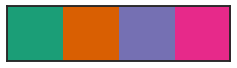

In [40]:
colorbrewer_dark = sns.color_palette(['#1b9e77', '#d95f02', '#7570b3', '#e7298a'])
sns.palplot(colorbrewer_dark)

TypeError: boxenplot() got an unexpected keyword argument 'alpha'

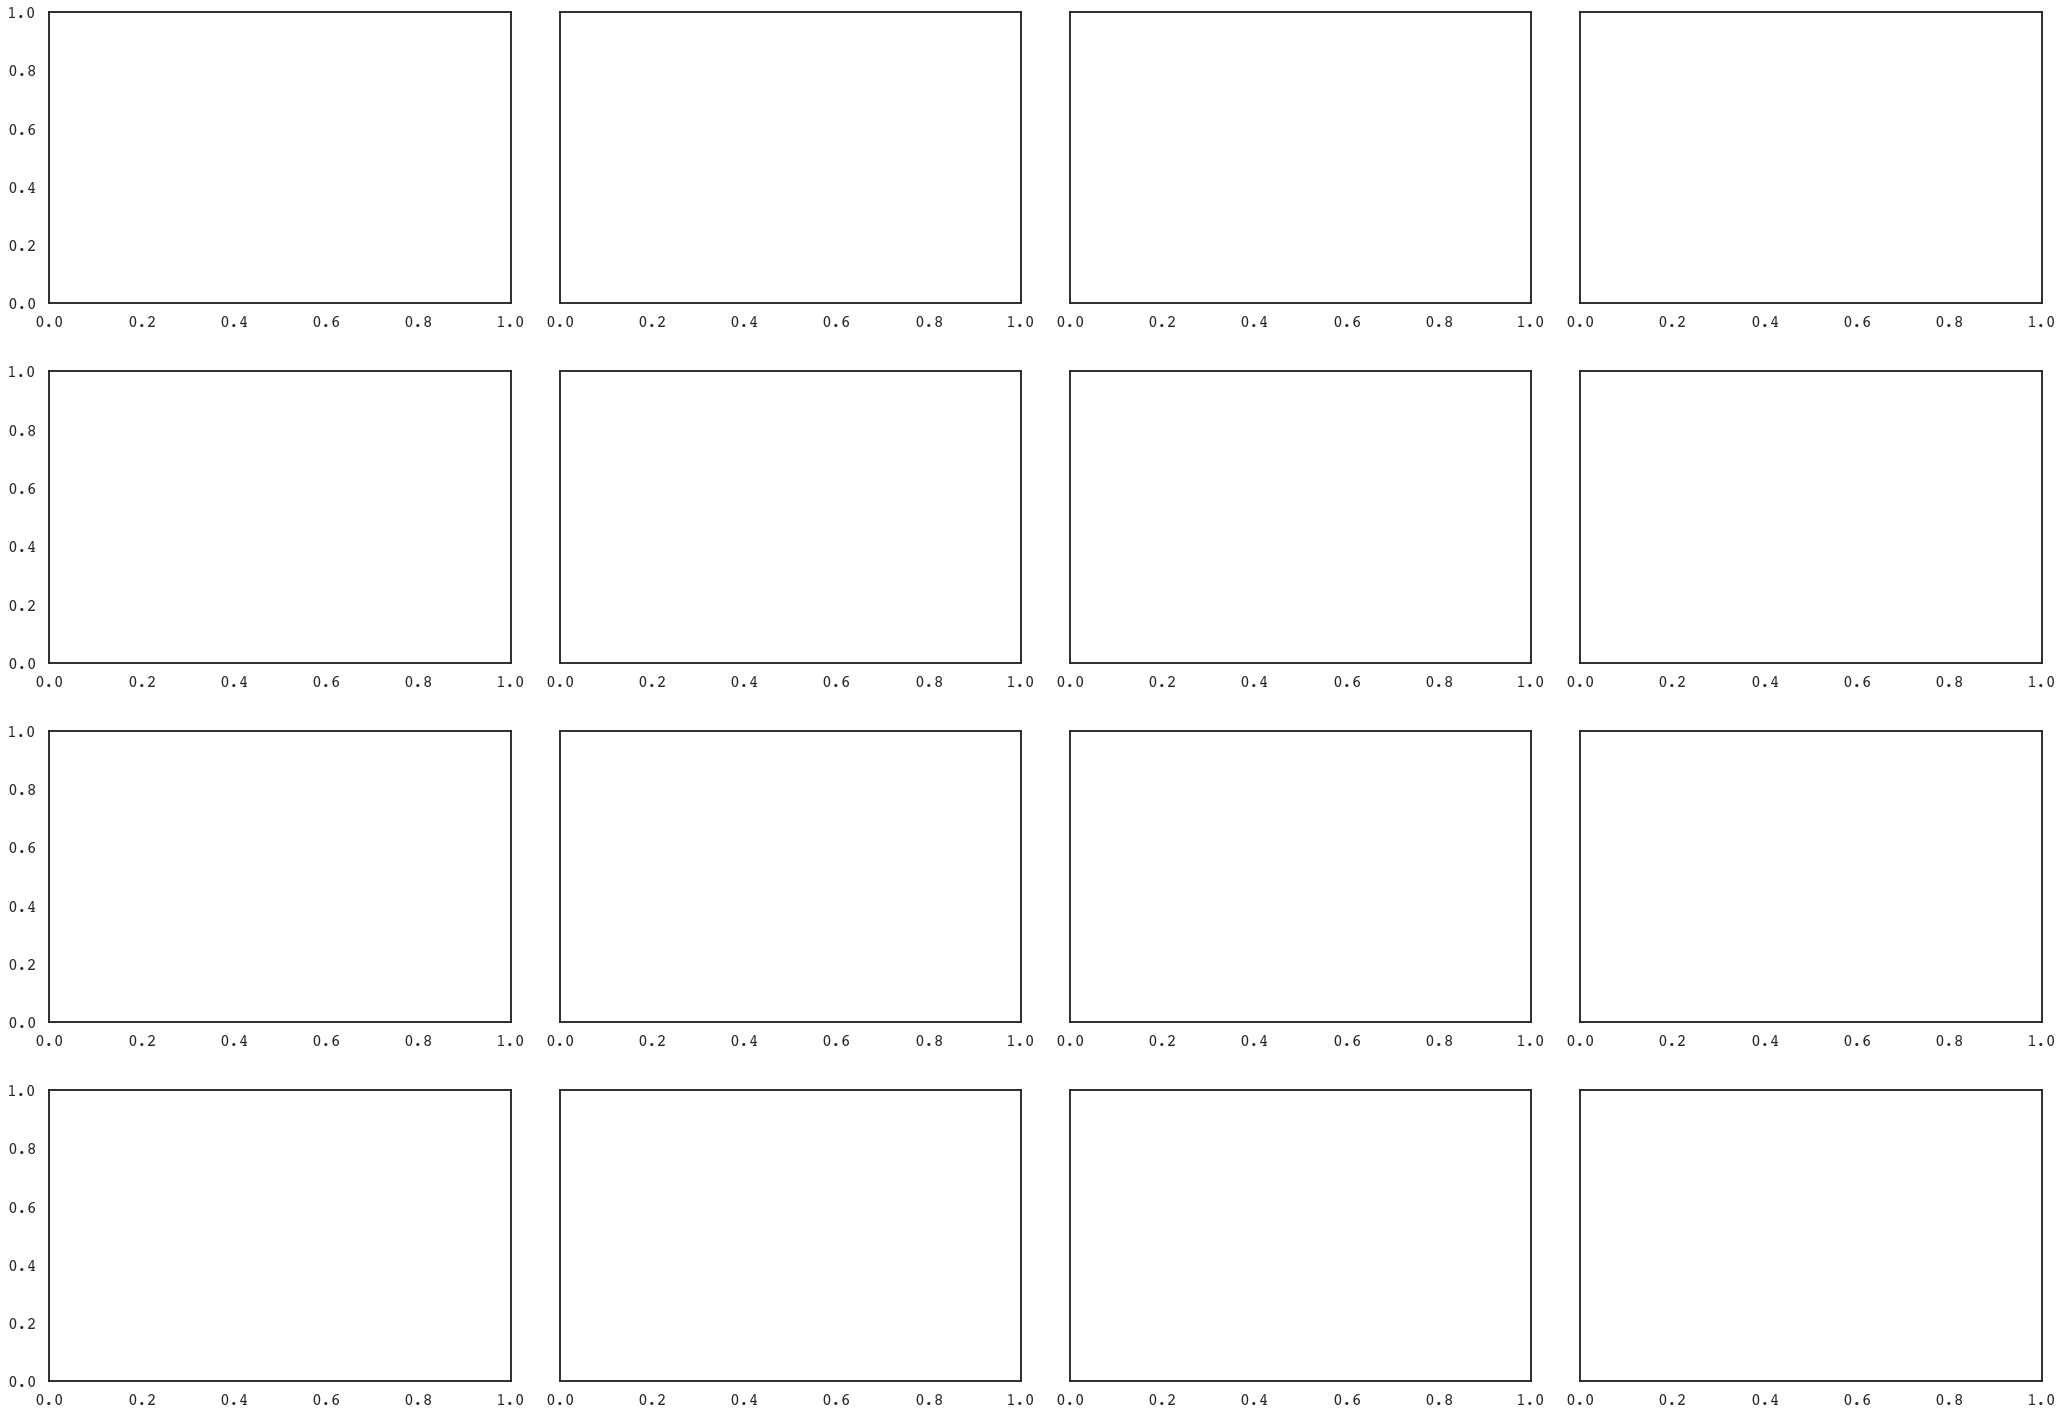

In [41]:
for fligner_var in list(hetero.keys()):
    var_name = hetero[fligner_var]['var']
    subsamples = {}
    strings = hetero[fligner_var]['strings']
    sig_strings = [f"{string}*" for string in strings]
    levels = hetero[fligner_var]['levels']
    cols = strings + sig_strings + ['measure', 'modality']
    variance = pd.DataFrame(index=var_df.index,
                            columns=cols)
    for i in range(0, len(hetero[fligner_var]['levels'])):
        level_val = levels[i]
        level_name = strings[i]
        #print(level_name, level_val, type(level_val))
        if type(level_val) == int:
            subsamples[level_name] = df[df[var_name] == level_val].index
        elif type(level_val) == float:
            subsamples[level_name] = df[df[var_name] == level_val].index
        elif type(level_val) == tuple:
            subsamples[level_name] = df[df[var_name].between(level_val[0], level_val[1], inclusive='both')].index
        elif type(level_val) == str:
            subsamples[level_name] = df[df[var_name] == level_val].index

    sig_hsk = var_df[var_df[(fligner_var,'sig')] == '**'].index
    for region in var_df.index:
        #variance.at[region, 'measure'] = 
        variance.at[region, 'modality'] = var_df.loc[region]['modality'][0]
        measure = var_df.loc[region]['measure'][0]
        #print(measure)
        variance.at[region, 'measure'] = measure
        variance.at[region, 'long_measure'] = long_names[measure]
        for string in strings:
            ppts = subsamples[string]
            if region in sig_hsk:
                variance.at[region, f'{string}*'] = np.var(df.loc[ppts][region])
            else:
                variance.at[region, string] = np.var(df.loc[ppts][region])

    colors = sns.husl_palette(n_colors=len(levels), h=0.01, s=0.8, l=0.65, as_cmap=False)
    darks = sns.husl_palette(n_colors=len(levels), h=0.01, s=0.9, l=0.40, as_cmap=False)
    color_list = colors.as_hex()
    dark_list = darks.as_hex()

    #measure_list = list(variance['measure'].dropna().unique())
    #print(variance.describe())
    fig,ax = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=True,  figsize=(29,20))
    #fig,ax = plt.subplots(ncols=3, sharex=False, sharey=True,  figsize=(21,7))
    plt.tight_layout(h_pad=2)
    new_measure_list = ['Cortical Thickness', 'Functional Variance', 'Fractional Anisotropy (WM)']
    
    for measure in new_measure_list:
        if measure == np.nan:
            pass
        else:
            i = new_measure_list.index(measure)
            #print(measure,i)
            if i in [0,1,2,3]:
                #axis = ax[0,i]
                axis = ax[0,i]
                #print(0, i)
            elif i in [4,5,6,7]:
                axis = ax[1,i-4]
                #print(1, i-4)
            elif i in [8,9,10,11]:
                axis = ax[2,i-8]
                #print(2,i-8)
            elif i in [12,13, 14, 15]:
                axis = ax[3, i-12]
                #print(3, i-12)
            melt = pd.melt(variance[variance['long_measure'] == measure], value_vars=strings)
            #print('measure\n', melt.describe())
            g = sns.boxenplot(data=melt, x='value', y='variable',hue='variable',  ax=axis, dodge=False, alpha=0.5, palette=colors)
            g.set_xlabel('Variance')
            if i in [0,4,8,12]:
                g.set_ylabel(f'{fligner_var.split("_")[-1]}'.capitalize())
            g.set_title(measure)
            is_legend = g.get_legend()
            if is_legend is not None:
                is_legend.remove()
            #print(sig_strings, np.mean(variance[variance['measure'] == measure][sig_strings[0]]))
            if np.sum(np.sum(variance[variance['long_measure'] == measure][sig_strings])) > 0:
                melt_sig = pd.melt(variance[variance['long_measure'] == measure], value_vars=sig_strings)
                #print('measure\n', melt_sig.describe())
                h = sns.boxenplot(data=melt_sig, x='value', y='variable', ax=axis, join=False,  
                                hue='variable', dodge=.1, errorbar=None, palette=darks)
                h = sns.stripplot(data=melt_sig, x='value', y='variable', hue='variable',  ax=axis, dodge=False, alpha=0.75, palette=darks)
                #means = {}
                for string in sig_strings:
                    j = sig_strings.index(string)
                    mean = np.mean(variance[variance['long_measure'] == measure][string])
                    axis.axvline(mean, lw=2, ls='--', color=dark_list[j], alpha=0.75)
                h.get_legend().remove()
            else:
                pass
            
            
            
    fig.savefig(join(PROJ_DIR, 
                     FIGS_DIR, 
                     f'{fligner_var.split("_")[-1]}_variance.png'), 
                dpi=500, 
                bbox_inches='tight')

In [ ]:
variance

In [ ]:
import warnings
warnings.filterwarnings('ignore')

list(age_variance['measure'].unique())
measure_list = ['gray matter volume',
                'cortical area', 
                'cortical thickness',
                'white matter volume', 
                'gm-wm contrast',
                'fractional anisotropy',
                 'mean diffusivity',
                 'longitudinal diffusivity',
                 'transverse diffusivity',
                'isotropic intracellular diffusion (GM)',
                'isotropic intracellular diffusion (WM)',
                'directional intracellular diffusion (GM)',
                'directional intracellular diffusion (WM)',
                'bold variance',
                'network connectivity',
                'subcortical-to-network connectivity']

fig,ax = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=True, figsize=(29,20))
plt.tight_layout(h_pad=2)
for measure in measure_list:
    i = measure_list.index(measure)
    print(measure,i)
    if i in [0,1,2,3]:
        axis = ax[0,i]
        #print(0, i)
    elif i in [4,5,6,7]:
        axis = ax[1,i-4]
        #print(1, i-4)
    elif i in [8,9,10,11]:
        axis = ax[2,i-8]
        #print(2,i-8)
    elif i in [12,13, 14, 15]:
        axis = ax[3, i-12]
        #print(3, i-12)
    melt = pd.melt(age_variance[age_variance['measure'] == measure], value_vars=['9-9.3', '9.4-9.9', '10-10.4', '10.5-11'])
    melt_sig = pd.melt(age_variance[age_variance['measure'] == measure], value_vars=['9-9.3*', '9.4-9.9*', '10-10.4*', '10.5-11*'])
    
    h = sns.pointplot(x='value', y='variable', data=melt_sig, ax=axis, join=False,  
                      markers='x', hue='variable', dodge=.1, ci=None, palette=colorbrewer_dark)
    h = sns.stripplot(x='value', y='variable', data=melt_sig, ax=axis, dodge=False, alpha=0.75, palette=colorbrewer_dark)
    g = sns.stripplot(x='value', y='variable', data=melt, ax=axis, dodge=False, alpha=0.2, palette=colorbrewer_dark)
    g.set_xlabel('Variance')
    if i in [0,4,8,12]:
        g.set_ylabel('Age (years)')
    g.set_title(measure.title())
    g.get_legend().remove()
    mean1 = np.mean(age_variance[age_variance['measure'] == measure]['9-9.3*'])
    mean2 = np.mean(age_variance[age_variance['measure'] == measure]['9.4-9.9*'])
    mean3 = np.mean(age_variance[age_variance['measure'] == measure]['10-10.4*'])
    mean4 = np.mean(age_variance[age_variance['measure'] == measure]['10.5-11*'])
    axis.axvline(mean1, lw=2, ls='--', color='#1b9e77', alpha=0.75)
    axis.axvline(mean2, lw=2, ls='--', color='#d95f02', alpha=0.75)
    axis.axvline(mean3, lw=2, ls='--', color='#7570b3', alpha=0.75)
    axis.axvline(mean4, lw=2, ls='--', color='#e7298a', alpha=0.75)
fig.savefig(join(PROJ_DIR,
               FIGS_DIR,
               f'age-brain_variance.png'), dpi=500, bbox_inches='tight')


puberty_variance = pd.DataFrame(index=var_df.index, 
                                columns=['pre', 'early', 'mid', 
                                         'pre*', 'early*', 'mid*',
                                         'late†', 'measure', 'modality'])

ppts1 = df[df[puberty] == 1.].index
ppts2 = df[df[puberty] == 2.].index
ppts3 = df[df[puberty] == 3.].index
ppts4 = df[df[puberty] == 4.].index
for measure in var_df['measure'].unique():
    # calculate the variance in each stage of puberty per region
    # and then plot it
    sig_hsk = var_df[var_df[('fligner_puberty','sig')] == '**'].index
    for region in var_df[var_df['measure'] == measure].index:
        puberty_variance.at[region, 'measure'] = long_names[measure]
        puberty_variance.at[region, 'modality'] = var_df.loc[region]['modality'][0]
        if region in sig_hsk:
            puberty_variance.at[region, 'pre*'] = np.var(df.loc[ppts1][region])
            puberty_variance.at[region, 'early*'] = np.var(df.loc[ppts2][region])
            puberty_variance.at[region, 'mid*'] = np.var(df.loc[ppts3][region])
        else:
            puberty_variance.at[region, 'pre'] = np.var(df.loc[ppts1][region])
            puberty_variance.at[region, 'early'] = np.var(df.loc[ppts2][region])
            puberty_variance.at[region, 'mid'] = np.var(df.loc[ppts3][region])
        puberty_variance.at[region, 'late†'] = np.var(df.loc[ppts4][region])
        

fig,ax = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=True, figsize=(29,20))
plt.tight_layout(h_pad=2)
for measure in measure_list:
    i = measure_list.index(measure)
    print(measure,i)
    if i in [0,1,2,3]:
        axis = ax[0,i]
        #print(0, i)
    elif i in [4,5,6,7]:
        axis = ax[1,i-4]
        #print(1, i-4)
    elif i in [8,9,10,11]:
        axis = ax[2,i-8]
        #print(2,i-8)
    elif i in [12,13, 14, 15]:
        axis = ax[3, i-12]
        #print(3, i-12)
    melt = pd.melt(puberty_variance[puberty_variance['measure'] == measure], value_vars=['pre', 'early', 'mid', 'late†'])
    melt_sig = pd.melt(puberty_variance[puberty_variance['measure'] == measure], value_vars=['pre*', 'early*', 'mid*'])

    h = sns.pointplot(x='value', y='variable', data=melt_sig, ax=axis, join=False,  
                      markers='x', hue='variable', dodge=.1, ci=None, palette=colorbrewer_dark)
    h = sns.stripplot(x='value', y='variable', data=melt_sig, ax=axis, dodge=False, alpha=0.75, palette=colorbrewer_dark)
    g = sns.stripplot(x='value', y='variable', data=melt, ax=axis, dodge=False, alpha=0.2, palette=colorbrewer_dark)
    g.set_xlabel('Variance')
    if i in [0,4,8,12]:
        g.set_ylabel('Pubertal Stage')
    g.set_title(measure.title())
    g.get_legend().remove()
    mean1 = np.mean(puberty_variance[puberty_variance['measure'] == measure]['pre*'])
    mean2 = np.mean(puberty_variance[puberty_variance['measure'] == measure]['early*'])
    mean3 = np.mean(puberty_variance[puberty_variance['measure'] == measure]['mid*'])
    axis.axvline(mean1, lw=2, ls='--', color='#1b9e77', alpha=0.75)
    axis.axvline(mean2, lw=2, ls='--', color='#d95f02', alpha=0.75)
    axis.axvline(mean3, lw=2, ls='--', color='#7570b3', alpha=0.75)
fig.savefig(join(PROJ_DIR,
               FIGS_DIR,
               f'puberty-brain_variance.png'), dpi=500, bbox_inches='tight')


sex_variance = pd.DataFrame(index=var_df.index, 
                                columns=['female', 'male', 
                                         'female*', 'male*', 
                                         'measure', 'modality'])

ppts1 = df[df[sex] == 'F'].index
ppts2 = df[df[sex] == 'M'].index

for measure in var_df['measure'].unique():
    # calculate the variance in each stage of sex per region
    # and then plot it
    sig_hsk = var_df[var_df[('fligner_sex','sig')] == '**'].index
    for region in var_df[var_df['measure'] == measure].index:
        sex_variance.at[region, 'measure'] = long_names[measure]
        sex_variance.at[region, 'modality'] = var_df.loc[region]['modality'][0]
        if region in sig_hsk:
            sex_variance.at[region, 'female*'] = np.var(df.loc[ppts1][region])
            sex_variance.at[region, 'male*'] = np.var(df.loc[ppts2][region])
        else:
            sex_variance.at[region, 'female'] = np.var(df.loc[ppts1][region])
            sex_variance.at[region, 'male'] = np.var(df.loc[ppts2][region])


fig,ax = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=True, figsize=(29,20))
plt.tight_layout(h_pad=2)
for measure in measure_list:
    i = measure_list.index(measure)
    print(measure,i)
    if i in [0,1,2,3]:
        axis = ax[0,i]
        #print(0, i)
    elif i in [4,5,6,7]:
        axis = ax[1,i-4]
        #print(1, i-4)
    elif i in [8,9,10,11]:
        axis = ax[2,i-8]
        #print(2,i-8)
    elif i in [12,13, 14, 15]:
        axis = ax[3, i-12]
        #print(3, i-12)
    melt = pd.melt(sex_variance[sex_variance['measure'] == measure], value_vars=['female', 'male'])
    melt_sig = pd.melt(sex_variance[sex_variance['measure'] == measure], value_vars=['female*', 'male*'])

    h = sns.pointplot(x='value', y='variable', data=melt_sig, ax=axis, join=False,  
                      markers='x', hue='variable', dodge=.1, ci=None, palette=colorbrewer_dark)
    h = sns.stripplot(x='value', y='variable', data=melt_sig, ax=axis, dodge=False, alpha=0.75, palette=colorbrewer_dark)
    g = sns.stripplot(x='value', y='variable', data=melt, ax=axis, dodge=False, alpha=0.2, palette=colorbrewer_dark)
    g.set_xlabel('Variance')
    if i in [0,4,8,12]:
        g.set_ylabel('Sex')
    g.set_title(measure.title())
    g.get_legend().remove()
    mean1 = np.mean(sex_variance[sex_variance['measure'] == measure]['female*'])
    mean2 = np.mean(sex_variance[sex_variance['measure'] == measure]['male*'])

    axis.axvline(mean1, lw=2, ls='--', color='#1b9e77', alpha=0.75)
    axis.axvline(mean2, lw=2, ls='--', color='#d95f02', alpha=0.75)

fig.savefig(join(PROJ_DIR,
               FIGS_DIR,
               f'sex-brain_variance.png'), dpi=500, bbox_inches='tight')


In [ ]:
sns.color_palette('OrRd', as_cmap=True)

for fligner_var in hetero.keys():
    print('\n\n',fligner_var)
    variable = fligner_var.split('_')[-1]
    var = hetero[fligner_var]['var']
    levels = hetero[fligner_var]['levels']
    strings = hetero[fligner_var]['strings']
    print(levels, strings)
    
    sig_measures = var_df[var_df[(fligner_var, 'sig')] == '**'].index
    top_50 = var_df[(fligner_var, 'stat')].sort_values()[-50:].index
    highest_heterosced = var_description.loc[top_50].describe()
    bot_50 = var_df[(fligner_var, 'stat')].sort_values()[:50].index
    lowest_heterosced = var_description.loc[bot_50].describe()
    print('HIGHEST-----\n', highest_heterosced)
    print('LOWEST-----\n', lowest_heterosced)
    
    if type(levels[0]) == int or type(levels[0]) == str or type(levels[0]) == float:
        fligner_df = df[df[var] == levels[0]]
    elif type(levels[0]) == tuple:
        it = levels[0]
        fligner_df = df[df[var].between(it[0], it[1])]
    fligner_df = pd.Series(fligner_df[var_df.index].var(), name=str(strings[0]))
    print(levels[0])

    for i in range(0, len(levels[1:])):
        level = levels[i+1]
        string = strings[i+1]
        print(string)
        if type(level) == int or type(level) == str or type(level) == float:
            temp_df = df[df[var] == level]
            print(len(temp_df.index))
        elif type(level) == tuple:
            temp_df = df[df[var].between(level[0], level[1])]
            print(len(temp_df.index))
        print(level)
        temp_df = pd.Series(temp_df[var_df.index].var(), name=string)
        fligner_df = pd.concat([temp_df, fligner_df], axis=1)
    #fligner_df = fligner_df.dropna(thresh=len(levels) - 1)
    #top_50_df = fligner_df.loc[top_50]
    #not_present = list(set(levels) - set(fligner_df.columns))
    stats = ['stat', 'pval']
    columns = pd.MultiIndex.from_product([stats, concepts + 'all'])
    mann_whitney_u = pd.DataFrame(columns=columns)
    for string in strings:
        dat = fligner_df[string].dropna()
        for string1 in strings:
            dat1 = fligner_df[string1].dropna()
            if string != string1:
                if len(dat.index) > 0 and len(dat1.index) > 0:
                    res = mannwhitneyu(dat, dat1, alternative='greater')
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'stat')] = res.statistic
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'pval')] = res.pvalue
                else:
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'stat')] = np.nan
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'pval')] = np.nan
            else:
                pass
    mann_whitney_u.to_csv(join('..', OUTP_DIR,f'mann_whitney_{variable}-variance_diff.csv'))
    #convert from variance to coefficient of variation (sdev / mean)
    heteroskedasticity = pd.Series(var_df[(fligner_var, 'stat'),(fligner_var, 'stat')], 
                                   name='heteroscedasticity')
    fligner_cov = np.sqrt(fligner_df) / fligner_df.mean(axis=0)
    fligner_cov = pd.concat([fligner_cov, var_description], axis=1)
    fligner_df = pd.concat([fligner_df, 
                            heteroskedasticity, 
                            var_description], axis=1)
    fligner_df.to_csv(join(PROJ_DIR, OUTP_DIR,f'heteroscedasticity_{variable}.csv'))
    
    str_levels = [str(level) for level in levels]
    long_fligner = fligner_df.loc[sig_measures].melt(value_vars=strings, 
                                    value_name='variance',
                                    var_name=variable,
                                    id_vars=var_description.columns)
    #long_fligner2 = fligner_cov.loc[sig_measures].melt(value_vars=strings, 
    #                                value_name='coeff_of_var',
    #                                var_name=variable,
    #                                id_vars=var_description.columns)
    fligner_df = None
    #k = sns.displot(
    #    data=long_fligner2,
    #    x=variable, y="coeff_of_var", col="concept",
    #    #col_order=, 
    #    log_scale=(False, True),
    #    #col_wrap=4, height=4, aspect=0.9,
    #    height=6, 
    #)
    #k.savefig(join('..', 
    #               FIGS_DIR, 
    #              f'heteroscedastic_{variable}_coefficient-of-variation.png'), dpi=500)

    n_colors = len(np.unique(long_fligner[variable]))
    morph_pal = sns.color_palette('OrRd', as_cmap=True)
    cell_pal = sns.color_palette('RdPu', as_cmap=True)
    func_pal = sns.color_palette('BuGn', as_cmap=True)
    
    
    #plt.tight_layout(w_pad=1)
    #g = sns.stripplot(x=variable, y="variance", hue=variable, 
    #                  alpha=0.25, dodge=True, marker='+',
    #               data=long_fligner[long_fligner['concept'] == 'macrostructure'], 
    #                   linewidth=1, palette=morph_pal, ax=ax)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = morph_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'macrostructure']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    h = sns.swarmplot(x=variable, y="variance", hue=variable, 
                      #inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'macrostructure'], 
                       linewidth=1, palette=morph_pal, ax=ax)
    # compute means
    
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    ax.legend().set_visible(False)
    ax.set_title('macrostructure')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-macro_variance.png'), dpi=500, bbox_inches='tight')
    fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=1)
    h = sns.violinplot(x=variable, y="variance", hue=variable, 
                      inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'microstructure'], 
                       linewidth=1, palette=cell_pal, ax=ax)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = cell_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'microstructure']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    #h = sns.pointplot(x=variable, y="variance", hue=variable, 
    #                  markers='x',
    #                  join=True,
    #                  data=long_fligner[long_fligner['concept'] == 'microstructure'],
    #                  linewidth=1, 
    #                  palette=cell_pal, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    ax.legend().set_visible(False)
    ax.set_title('microstructure')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-micro_variance.png'), dpi=500, bbox_inches='tight')
    #fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=1)
    #g = sns.boxenplot(x=variable, y="variance", hue=variable,
    #               data=long_fligner[long_fligner['concept'] == 'function'], 
    #                   linewidth=1, palette=palette, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    #ax.legend().set_visible(False)
    #ax.set_title('function')
    #fig.savefig(join('..',
    #               FIGS_DIR,
    #               f'{variable}-fxn_variance.png'), dpi=500, bbox_inches='tight')
    fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=5)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = func_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'function']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    h = sns.violinplot(x=variable, y="variance", hue=variable, 
                      inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'function'], 
                       linewidth=1, palette=func_pal, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    #ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.legend().set_visible(False)
    ax.set_title('function')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-func_variance.png'), dpi=500, bbox_inches='tight')

for i in var_df.index:
    if i in btwn_fc:
        var_df.at[i, 'measure'] = 'between-network fc'
        puberty_variance.at[i, 'measure'] = 'between-network fc'
    elif i in wthn_fc:
        var_df.at[i, 'measure'] = 'within-network fc'
        puberty_variance.at[i, 'measure'] = 'within-network fc'
    elif i in fc_scor_var:
        var_df.at[i, 'measure'] = 'subcortical-network fc'
        puberty_variance.at[i, 'measure'] = 'subcortical-network fc'

In [ ]:
# let's visualize this variability!
destrieux = datasets.fetch_atlas_destrieux_2009()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

sum_puberty_variance = pd.DataFrame(index=puberty_variance['measure'].unique(),
                                    columns=['pre', 'early', 'mid', 
                                             'pre*', 'early*', 'mid*', 'late†'])
std_puberty_variance = pd.DataFrame(index=puberty_variance['measure'].unique(),
                                    columns=['pre', 'early', 'mid', 
                                             'pre*', 'early*', 'mid*', 'late†'])
for measure in puberty_variance['measure'].unique():
    temp_df = puberty_variance[puberty_variance['measure'] == measure]
    sum_puberty_variance.at[measure, 'pre'] = np.mean(temp_df['pre'])
    sum_puberty_variance.at[measure, 'early'] = np.mean(temp_df['early'])
    sum_puberty_variance.at[measure, 'mid'] = np.mean(temp_df['mid'])
    sum_puberty_variance.at[measure, 'pre*'] = np.mean(temp_df['pre*'])
    sum_puberty_variance.at[measure, 'early*'] = np.mean(temp_df['early*'])
    sum_puberty_variance.at[measure, 'mid*'] = np.mean(temp_df['mid*'])
    sum_puberty_variance.at[measure, 'late†'] = np.mean(temp_df['late†'])
    std_puberty_variance.at[measure, 'pre'] = np.std(temp_df['pre'])
    std_puberty_variance.at[measure, 'early'] = np.std(temp_df['early'])
    std_puberty_variance.at[measure, 'mid'] = np.std(temp_df['mid'])
    std_puberty_variance.at[measure, 'pre*'] = np.std(temp_df['pre*'])
    std_puberty_variance.at[measure, 'early*'] = np.std(temp_df['early*'])
    std_puberty_variance.at[measure, 'mid*'] = np.std(temp_df['mid*'])
    std_puberty_variance.at[measure, 'late†'] = np.std(temp_df['late†'])

sum_puberty_variance.to_csv(join(PROJ_DIR, OUTP_DIR, 'mean_variance_across_PDS.csv'))
std_puberty_variance.to_csv(join(PROJ_DIR, OUTP_DIR, 'sdev_variance_across_PDS.csv'))

In [ ]:
scs_1 = ['x',
         'x',
         'x',
         'x',
        "tplh",
        "caudatelh",
        "putamenlh",
        "pallidumlh",
        "bstem",
        "hpuslh",
        "amygdalalh",
        "aal",
        'x',
        'x',
         'x',
        "tprh",
        "caudaterh",
        "putamenrh",
        "pallidumrh",
        "hpusrh",
        "amygdalarh",
        "aar"]

In [ ]:
abcd_to_harvox = pd.DataFrame(columns=['label', 'Volume', 
                                       'T1w Intensity', 
                                       'Restricted Normalized Directional Diffusion', 
                                       'Restricted Normalized Isotropic Diffusion'])

for i in range(0, len(subcort.labels)):
    label = subcort.labels[i]
    abcd_to_harvox.at[i, 'label'] = label
    if scs_1[i] == 'x':
        abcd_to_harvox.at[i, 'Volume'] = np.nan
        abcd_to_harvox.at[i, 'T1w Intensity'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = np.nan
    else:
        abcd_to_harvox.at[i, 'Volume'] = f'smri_vol_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'T1w Intensity'] = f'smri_t1w_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = f'dmri_rsirnd_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = f'dmri_rsirni_scs_{scs_1[i]}'

In [ ]:
abcd_to_harvox.columns[1:]

sc_array = subcort.filename.get_fdata()
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            plotting_arr[np.where(sc_array == i)] = var_df.at[f'{abcd_var}.change_score',('variance', 'stat')]
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='gist_rainbow', colorbar=False, title=column,
                           vmax=30., symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'../figures/{column}_variance.png', dpi=400)

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()

In [ ]:
nifti_mapping = pd.read_csv(join(PROJ_DIR, 
                                 DATA_DIR, 
                                 'variable_to_nifti_mapping.csv'), 
                            header=0, 
                            index_col=0)

In [ ]:
vol_mapping = {'smri_vol_cdk_banksstslh.change_score': 1001.0,
    'smri_vol_cdk_cdacatelh.change_score': 1002.0,
    'smri_vol_cdk_cdmdfrlh.change_score': 1003.0,
    'smri_vol_cdk_cuneuslh.change_score': 1005.0,
    'smri_vol_cdk_ehinallh.change_score': 1006.0,
    'smri_vol_cdk_fusiformlh.change_score': 1007.0,
    'smri_vol_cdk_ifpllh.change_score': 1008.0,
    'smri_vol_cdk_iftmlh.change_score': 1009.0,
    'smri_vol_cdk_ihcatelh.change_score': 1010.0,
    'smri_vol_cdk_locclh.change_score': 1011.0,
    'smri_vol_cdk_lobfrlh.change_score': 1012.0,
    'smri_vol_cdk_linguallh.change_score': 1013.0,
    'smri_vol_cdk_mobfrlh.change_score': 1014.0,
    'smri_vol_cdk_mdtmlh.change_score': 1015.0,
    'smri_vol_cdk_parahpallh.change_score': 1016.0,
    'smri_vol_cdk_paracnlh.change_score': 1017.0,
    'smri_vol_cdk_parsopclh.change_score': 1018.0,
    'smri_vol_cdk_parsobislh.change_score': 1019.0,
    'smri_vol_cdk_parstgrislh.change_score': 1020.0,
    'smri_vol_cdk_pericclh.change_score': 1021.0,
    'smri_vol_cdk_postcnlh.change_score': 1022.0,
    'smri_vol_cdk_ptcatelh.change_score': 1023.0,
    'smri_vol_cdk_precnlh.change_score': 1024.0,
    'smri_vol_cdk_pclh.change_score': 1025.0,
    'smri_vol_cdk_rracatelh.change_score': 1026.0,
    'smri_vol_cdk_rrmdfrlh.change_score': 1027.0,
    'smri_vol_cdk_sufrlh.change_score': 1028.0,
    'smri_vol_cdk_supllh.change_score': 1029.0,
    'smri_vol_cdk_sutmlh.change_score': 1030.0,
    'smri_vol_cdk_smlh.change_score': 1031.0,
    'smri_vol_cdk_frpolelh.change_score': 1032.0,
    'smri_vol_cdk_tmpolelh.change_score': 1033.0,
    'smri_vol_cdk_trvtmlh.change_score': 1034.0,
    'smri_vol_cdk_insulalh.change_score': 1035.0,
    'smri_vol_cdk_banksstsrh.change_score': 2001.0,
    'smri_vol_cdk_cdacaterh.change_score': 2002.0,
    'smri_vol_cdk_cdmdfrrh.change_score': 2003.0,
    'smri_vol_cdk_cuneusrh.change_score': 2005.0,
    'smri_vol_cdk_ehinalrh.change_score': 2006.0,
    'smri_vol_cdk_fusiformrh.change_score': 2007.0,
    'smri_vol_cdk_ifplrh.change_score': 2008.0,
    'smri_vol_cdk_iftmrh.change_score': 2009.0,
    'smri_vol_cdk_ihcaterh.change_score': 2010.0,
    'smri_vol_cdk_loccrh.change_score': 2011.0,
    'smri_vol_cdk_lobfrrh.change_score': 2012.0,
    'smri_vol_cdk_lingualrh.change_score': 2013.0,
    'smri_vol_cdk_mobfrrh.change_score': 2014.0,
    'smri_vol_cdk_mdtmrh.change_score': 2015.0,
    'smri_vol_cdk_parahpalrh.change_score': 2016.0,
    'smri_vol_cdk_paracnrh.change_score': 2017.0,
    'smri_vol_cdk_parsopcrh.change_score': 2018.0,
    'smri_vol_cdk_parsobisrh.change_score': 2019.0,
    'smri_vol_cdk_parstgrisrh.change_score': 2020.0,
    'smri_vol_cdk_periccrh.change_score': 2021.0,
    'smri_vol_cdk_postcnrh.change_score': 2022.0,
    'smri_vol_cdk_ptcaterh.change_score': 2023.0,
    'smri_vol_cdk_precnrh.change_score': 2024.0,
    'smri_vol_cdk_pcrh.change_score': 2025.0,
    'smri_vol_cdk_rracaterh.change_score': 2026.0,
    'smri_vol_cdk_rrmdfrrh.change_score': 2027.0,
    'smri_vol_cdk_sufrrh.change_score': 2028.0,
    'smri_vol_cdk_suplrh.change_score': 2029.0,
    'smri_vol_cdk_sutmrh.change_score': 2030.0,
    'smri_vol_cdk_smrh.change_score': 2031.0,
    'smri_vol_cdk_frpolerh.change_score': 2032.0,
    'smri_vol_cdk_tmpolerh.change_score': 2033.0,
    'smri_vol_cdk_trvtmrh.change_score': 2034.0,
    'smri_vol_cdk_insularh.change_score': 2035.0,}

In [ ]:
for vol_var in vol_mapping.keys():
    var = vol_var.split('.')[0]
    nifti_mapping.at[var,'atlas_value'] = vol_mapping[vol_var]

In [ ]:
var_df.measure.unique()

In [ ]:
morph_pal = sns.cubehelix_palette(start=0.6, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=1, light=0.9, dark=0.4, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(start=1.7, rot=-0.8, gamma=1.0, hue=1, light=0.7, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=7, start=1.7, rot=-0.8, gamma=1.0, hue=1, light=0.9, dark=0.4, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(start=3.0, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=1, light=0.8, dark=0.4, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal
sns.palplot(big_pal)


In [ ]:
# list of measures to plot
measures = {'subcortical-RND': 'dmri_rsirnd_scs_.*',
            'subcortical-RNI': 'dmri_rsirni_scs_.*',
    'cortical-thickness': 'smri_thick_cdk_*',
            'cortical-gwcontrast': 'smri_t1wcnt_cdk_*',
            'cortical-area': 'smri_area_cdk_.*',
            'cortical-volume': 'smri_vol_cdk_.*', 
            'subcortical-volume': 'smri_vol_scs_.*', 
            
            'cortical-RND': 'dmri_rsirndgm_.*',
            'cortical-RNI': 'dmri_rsirnigm_.*',
            'cortical-BOLD-variance': 'rsfmri_var_cdk_.*',
            'tract-volume': 'dmri_dtivol_fiberat_.*', 
            'tract-FA': 'dmri_dtifa_fiberat_.*', 
            'tract-MD': 'dmri_dtimd_fiberat_.*',
            'tract-LD': 'dmri_dtild_fiberat_.*', 
            'tract-TD': 'dmri_dtitd_fiberat_.*', 
            'tract-RND': 'dmri_rsirnd_fib_.*',
            'tract-RNI': 'dmri_rsirni_fib_.*'
           }
vmax = 30
#cmap = 'viridis'

conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*',
            'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*',}


pals = {'cortical-thickness': morph_cmap,
        'cortical-gwcontrast': cell_cmap,
            'cortical-area': morph_cmap,
            'cortical-volume': morph_cmap, 
            'subcortical-volume': morph_cmap, 
            'subcortical-RND': cell_cmap,
            'subcortical-RNI': cell_cmap,
            'cortical-RND': cell_cmap,
            'cortical-RNI': cell_cmap,
            'cortical-BOLD-variance': func_cmap,
            'tract-volume': morph_cmap, 
            'tract-FA': cell_cmap, 
            'tract-MD': cell_cmap,
        'tract-LD': cell_cmap, 
            'tract-TD': cell_cmap,
            'tract-RND': cell_cmap,
            'tract-RNI': cell_cmap,
        'cortical-network-connectivity': func_cmap,
            'subcortical-network-connectivity': func_cmap}

In [ ]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns


func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

# test run plotting wm tracts not on a t1 (until I can get them properly registered)

for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1] 
    for measure in tract_measures.keys():
        fibers = nifti_mapping.filter(regex=tract_measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    #print(np.unique(tract_arr))
                    if var_df.at[f'{var}.change_score',(fligner_var, 'a<0.05')] == '**':
                        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                    else:
                        tract_arr *= 0
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_glass_brain(meas_nimg, display_mode='z',  
                                   vmax=vmax*1.1, 
                                vmin=10,
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   #axes=ax[0]
                              )
        #q.add_edges(meas_nimg)
        #q.savefig(f'../figures/{fligner}x{measure}_fk.png', dpi=400)
        q = None

In [ ]:
# raceth = 21 to 101
# income = 19 to 63
# edu = 22 to 56
# marital = 16 to 52

In [ ]:
morph_pal = sns.color_palette('OrRd_r', n_colors=4)
cell_pal = sns.color_palette('RdPu_r', n_colors=4)
func_pal = sns.color_palette('BuGn_r', n_colors=4)

colors = ['#000000', '#000000', '#000000', '#000000'] + morph_pal.as_hex()
morph_pal = sns.blend_palette(colors, as_cmap=True)

colors = ['#000000', '#000000', '#000000', '#000000'] + cell_pal.as_hex()
cell_pal = sns.blend_palette(colors, as_cmap=True)

colors = ['#000000', '#000000', '#000000', '#000000'] + func_pal.as_hex()
func_pal = sns.blend_palette(colors, as_cmap=True)

In [ ]:

morph_cmap = sns.diverging_palette(250, 256.3, s=90, l=60, center="dark", as_cmap=True)
func_cmap = sns.diverging_palette(250, 140.9, s=90, l=60, center="dark", as_cmap=True)
cell_cmap = sns.diverging_palette(250, 294.3, s=90, l=60, center="dark", as_cmap=True)

In [ ]:
vmax = 30

In [ ]:
corrs = var_df.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

corrs = var_df.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

In [ ]:
np.mean(list(var_df.loc[wthn_fc]['fligner_sex']['stat'].values))

In [ ]:
btwn_fc_src = [i.split('.')[0].split('_')[3] for i in btwn_fc]
btwn_fc_trgt = [i.split('.')[0].split('_')[-1] for i in btwn_fc]

In [ ]:
sns.kdeplot(var_df[var_df[('fligner_age', 'sig')] == '**'][('fligner_age', 'stat')])

In [ ]:
fc_scor_var
scs_varnames = [i.split('.')[0].split('_')[-1] for i in fc_scor_var]

In [ ]:
temp_df.head()

In [ ]:
sns.set(style='white', context='poster')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [ ]:
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    print(fligner)
    meas_df = var_df.loc[fc_scor_var]
    
    meas_df.loc[fc_scor_var, 'scs'] = scs_varnames
    avgs = pd.DataFrame()
    nsig = 0
    for scs in np.unique(scs_varnames):
        sig = []
        temp_df = meas_df[meas_df['scs'] == scs]
        # calculate average heteroscedasticity of all 
        # significantly heteroscedastic network connections
        
        #for every network connected to this subcortical region
        for i in temp_df.index:
            # if that connection is significant
            if temp_df.loc[i, (fligner_var, 'sig')] == '**':
                print(i, temp_df.loc[i,(fligner_var, 'stat')])
                # add that value to a list
                sig.append(temp_df.loc[i,(fligner_var, 'stat')])
                nsig += 1
            else:
                pass
        # average all significant HSKs for that region
        mean_hsk = np.mean(sig)
        #print(mean_hsk)
        # grab name of first conn var for this network for plotting
        avgs.at[temp_df.index[0], 'fk'] = mean_hsk
        #print(temp_df.index[0], mean_hsk)
    #print(nsig)
    meas_vars = [i.split('.')[0] for i in avgs.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    #print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in avgs.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        #print(i, avgs.at[i,'fk'])
        if value is np.nan:
            pass
        else:
            plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'fk']        
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    fig,ax = plt.subplots(figsize=(4,2)
                    )
    
    plt.figure(layout='tight')
    q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                           #cut_coords=[-20, -10, 0, 10], 
                               cut_coords=4,
                               vmax=vmax*1.1, 
                           annotate=True, cmap=func_cmap, colorbar=False,
                           symmetric_cbar=False, axes=ax)

    #ax[1].set_visible(False)
    #q.savefig(f'{PROJ_DIR}/figures/{fligner}xFCs_fk_scs.png', dpi=600)
    fig.savefig(f'{PROJ_DIR}/figures/{fligner}xFCs_fk_scs-fig.png', dpi=600, bbox_inches='tight')

In [ ]:
# okay, now we're plotting between and within network connectivity
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    
    #within-network fc is easy to plot bc there's only one HSK value per network (per fligner_var)
    meas_df = var_df.loc[wthn_fc]
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in meas_df.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        #print(i, value)
        if value is np.nan:
            pass
        else:
            if var_df.at[i,(fligner_var, 'sig')] == '**':
                sig += 1
                plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
            else:
                plotting_arr[np.where(atlas_arr == value)] = 0
    print('plotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions')
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, 1)
    figure.savefig(f'{PROJ_DIR}/figures/{fligner}xFCw_fk.png', dpi=400)
    
    # between-network FC is tough bc we have to average all of a networks HSK values
    # but only the significantly HSK connections
    sig = []
    meas_df = var_df.loc[btwn_fc]
    meas_df.loc[btwn_fc, 'from_ntwk'] = btwn_fc_src
    meas_df.loc[btwn_fc, 'to_ntwk'] = btwn_fc_trgt
    avgs = pd.DataFrame()
    for ntwk in np.unique(btwn_fc_src):
        
        temp_df = meas_df[meas_df['from_ntwk'] == ntwk]
        temp_df2 = meas_df[meas_df['to_ntwk'] == ntwk]
        temp_df = pd.concat([temp_df, temp_df2], axis=0)
        # calculate average heteroscedasticity of all 
        # significantly heteroscedastic network connections
        for i in temp_df.index:
            if temp_df.loc[i, (fligner_var, 'sig')] == '**':
                sig.append(temp_df.loc[i,(fligner_var, 'stat')])
            else:
                pass
        mean_hsk = np.mean(sig)
        # grab name of first conn var for this network for plotting
        avgs.at[temp_df.index[0], 'fk'] = mean_hsk
    meas_vars = [i.split('.')[0] for i in avgs.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in avgs.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        #print(i, value)
        if value is np.nan:
            pass
        else:
            plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'fk']        
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, 1)
    figure.savefig(f'{PROJ_DIR}/figures/{fligner}xFCb_fk.png', dpi=400)

In [ ]:
sns.set(style='white', context='poster')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [ ]:
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    print(fligner)
    #if fligner == 'scanner':
    #    vmax = vmax_scanner
    #else:
    #    vmax = vmax_other
    vmax = 30
    for measure in measures:
        print(f'\t{measure}')
        meas_df = var_df.filter(regex=measures[measure], axis=0)
        if 'tract' in measure:
            fibers = nifti_mapping.filter(regex=tract_measures[measure], axis=0).index
            var = fibers[0]
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            tract_nii = nib.load(tract_fname)
            tract_arr = tract_nii.get_fdata()
            #print(np.unique(tract_arr))
            if var_df.at[f'{var}.change_score',(fligner_var, 'sig')] == '**':
                tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
            else:
                tract_arr *= 0
            all_tracts_arr = np.zeros(tract_arr.shape)
            nv_arr = np.zeros(tract_arr.shape)
            all_tracts_arr += tract_arr
            for var in fibers[1:]:    
                tract_fname = nifti_mapping.loc[var]['atlas_fname']
                if type(tract_fname) is str:
                    try:
                        tract_nii = nib.load(tract_fname)
                        tract_arr = tract_nii.get_fdata()
                        #print(np.unique(tract_arr))
                        nv_arr += tract_arr * (np.log10(var_df.at[i,(fligner_var, 'p')]) * -1)
                        if var_df.at[f'{var}.change_score',(fligner_var, 'sig')] == '**':
                            tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                        else:
                            tract_arr *= 0
                        all_tracts_arr += tract_arr
                    except Exception as e:
                        pass
                else:
                    pass
            meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
            nv_nimg = nib.Nifti1Image(nv_arr, atlas_nii.affine).to_filename(f'{PROJ_DIR}/{OUTP_DIR}/{fligner}_nlogp_{measure}.nii')
            meas_nimg.to_filename(f'{PROJ_DIR}/{OUTP_DIR}/{fligner}_{measure}.nii')
            fig2,ax2 = plt.subplots(figsize=(4,2)
                                    )
            plt.figure(layout='tight')
            q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                                    #cut_coords=[-20, 0, 18, 40], 
                                    cut_coords=4,
                                    vmax=vmax*1.1, 
                                    annotate=True, cmap=pals[measure], colorbar=False,
                                    symmetric_cbar=False, axes=ax2)
            #q.add_edges(meas_nimg)
            fig2.savefig(f'{PROJ_DIR}/figures/{fligner}x{measure}_fk.png', dpi=600, bbox_inches='tight')
            plt.close(fig2)
        else:
            #print(len(meas_df.index))
            meas_vars = [i.split('.')[0] for i in meas_df.index]
            atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
            #print(atlas_fname)
            atlas_nii = nib.load(atlas_fname)
            atlas_arr = atlas_nii.get_fdata()
            plotting_arr = np.zeros(atlas_arr.shape)
            nv_arr = np.zeros(atlas_arr.shape)
            sig = 0
            for i in meas_df.index:
                if 'cdk_total' in i:
                    pass
                else:
                    j = i.split('.')[0]
                    value = nifti_mapping.loc[j]['atlas_value']
                    #print(i, value)
                    if value is np.nan:
                        pass
                    else:
                        nv_arr[np.where(atlas_arr == value)] = - np.log10(var_df.at[i,(fligner_var, 'p')])
                        if var_df.at[i,(fligner_var, 'sig')] == '**':
                            sig += 1
                            plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
                        else:
                            plotting_arr[np.where(atlas_arr == value)] = 0
            nv_nimg = nib.Nifti1Image(nv_arr, atlas_nii.affine).to_filename(f'{PROJ_DIR}/{OUTP_DIR}/{fligner}_nlogp_{measure}.nii')
            print('\t\tplotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions\n\t\tavg val: {np.mean(plotting_arr)}')
            meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
            meas_nimg.to_filename(f'{PROJ_DIR}/{OUTP_DIR}/{fligner}_{measure}.nii')
            if 'subcortical' in measure:
                grid_kw = dict(width_ratios=[3,1])
                
                fig,ax = plt.subplots(#ncols=2, gridspec_kw=grid_kw, figsize=(24,4)
                                    )
                plt.figure(layout='tight')
                v = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                                    #cut_coords=[-20, -10, 0, 10], 
                                    cut_coords=4,
                                    vmax=vmax*1.1, 
                                    annotate=True, cmap=pals[measure], colorbar=False,
                                    symmetric_cbar=False, axes=ax)

                #ax[1].set_visible(False)
                fig.savefig(f'{PROJ_DIR}/figures/{fligner}x{measure}_fk_scs.png', dpi=600, bbox_inches='tight')
                plt.close(fig)
            
            elif 'cortical' in measure:
                figure = plot_surfaces(meas_nimg, fsaverage, pals[measure], vmax, 1)
                #texture_l = surface.vol_to_surf(meas_nimg, fsaverage.pial_left, interpolation='nearest')
                #texture_r = surface.vol_to_surf(meas_nimg, fsaverage.pial_right, interpolation='nearest')

                #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                                    #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
                #plt.tight_layout(pad=2)
                #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftmed.png', dpi=600)
                #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                                    #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
                #plt.tight_layout(pad=2)
                #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftlat.png', dpi=600)
                #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                                    #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
                #plt.tight_layout(pad=2)
                #figure.savefig(f'../figures/{measure}x{fligner}_fk_rightlat.png', dpi=600)
                #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                                    #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
                #plt.tight_layout(pad=2)
                figure.savefig(f'{PROJ_DIR}/figures/{fligner}x{measure}_fk.png', dpi=600)
                plt.close()

In [ ]:
plotting_arr.max()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=func_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/func-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=cell_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/cell-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=morph_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/morph-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)

In [ ]:
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=func_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )